### Data augmentation notebook

This notebook provides a step by step review of the data augmentation process using the PASCAL VOC 2012 dataset. A comprehensive list of image transformations is provided in `image_utils.py`.

This notebook will first check if the dataset has already been downloaded and extracted. If not, it will attempt to do it. The dataset train and validation sets are then tranformed into TFRecordDatasets.

In [11]:
import os, importlib, sys, random, shutil
import os.path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops
from distutils.version import LooseVersion

import image_utils as utils
import pascal_voc_downloader as downloader
from pascal_voc_dataset import PascalVOC2012Dataset


def reload_libs():
    importlib.reload(sys.modules['image_utils'])
    importlib.reload(sys.modules['pascal_voc_dataset'])


%matplotlib inline
# This model has been tested with TF1.12. Using at least version 1.8 is only a suggestion.
assert LooseVersion(tf.__version__) >= LooseVersion('1.8'), 'Please use TensorFlow version 1.8 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow version {}'.format(tf.__version__))
print('Keras version      {}'.format(tf.keras.__version__))
assert K.image_data_format() == 'channels_last'
assert K.floatx() == 'float32'

TensorFlow version 1.12.0
Keras version      2.1.6-tf


Are you interested in a black theme for Jupyter notebooks? If yes, then copy the `dark_theme.css` to your .jupyter configuration directory and replace the path(s) below with your own location(s). Otherwise just remove this cell.

In [12]:
# Load a custom CSS for this Notebook
from IPython.display import HTML

# Add a css file location for each of your platforms
css_filenames = ['c:/users/asus-ux510/.jupyter/dark_theme.css', 
                 'c:/users/florent/.jupyter/dark_theme.css', 
                 'd:/userfiles/fmahoudeau/documents/.jupyter/dark_theme.css',
                 '/home/flo/.jupyter/dark_theme.css']

css = None
for css_filename in css_filenames:
    if os.path.isfile(css_filename):
        css = '<style>{}</style>'.format(open(css_filename).read())

HTML(css)

In [13]:
dataset = PascalVOC2012Dataset(augmentation_params=None)
N_CLASSES = 21  # Excluding the ignore/void class
CLASS_LABELS = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
                'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
                'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
assert len(CLASS_LABELS) == (N_CLASSES+1)
BATCH_SIZE = 12
IMAGE_SHAPE = (512, 512)  # Includes (12, 12) padding such that the height and width are divisible by 32

## Download and extract the data

In [14]:
if os.path.isdir('C:/Users/fmahoudeau/'):
    HOME_PATH = 'C:/Users/fmahoudeau/PycharmProjects/'
    DATA_ROOT_PATH = 'C:/Users/fmahoudeau/Datasets/'
elif os.path.isdir('C:/Users/Florent/'):
    HOME_PATH = 'C:/Users/Florent/'
    DATA_ROOT_PATH = 'G:/Datasets/'
else:
    assert False, 'Cannot resolve home directory'

DATASET_URL = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'pascal_voc_data')

# Images are stored in JPEG format, and segmentation ground truth in PNG format
IM_PATH = os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/JPEGImages')  # Location of images
GT_PATH = os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/SegmentationClass')  # Location of ground truth

# Location for saving ground truth pixels' labels in sparse format
GT_SPARSE_PATH = os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/SegmentationSparseClass')

# Create dataset root folder
if not os.path.exists(DATASET_PATH):
    print('Creating dataset root folder')
    os.makedirs(DATASET_PATH)
else:
    print('Dataset root folder already exists')

Dataset root folder already exists


Download the dataset

In [15]:
tarball_path = os.path.join(DATASET_PATH, DATASET_URL.split('/')[-1])

if not os.path.exists(tarball_path):
    downloader.download_dataset(DATASET_URL, DATASET_PATH)
else:
    print('Dataset file already downloaded')

Dataset file already downloaded


Check the existence of the first image in the dataset has indication of whether the tarball needs to be extacted or not.

In [16]:
if not os.path.exists(os.path.join(IM_PATH, '2007_000027.jpg')):
    downloader.extract_dataset(tarball_path, DATASET_PATH)
else:
    print('Tarball already extracted')

Tarball already extracted


Parse `train.txt` and `val.txt` files which contain the base names of the images that are labeled for semantic segmentation. 

These 2 lists are used to load images in this Notebook.

In [19]:
train_basenames = dataset.get_basenames('train', os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/'))
print('Found', len(train_basenames), 'training samples')

val_basenames = dataset.get_basenames('val', os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/'))
print('Found', len(val_basenames), 'validation samples')

Found 1464 training samples
Found 1449 validation samples


## Preparing the dataset

### Sparse encoding of segmentation class images

To save CPU resources during data augmentation, the ground truth colored images are converted to sparse labels. I did not use it for the final solution as I used TFRecordDataset instead. Nevertheless, this function might be handy if you prefer to feed the model with numpy arrays as the loss expects sparse labels.

In [21]:
# Encode and save sparse ground truth segmentation image labels
print('Exporting training set sparse labels...')
dataset.export_sparse_encoding('train', os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/'))
print('Exporting validation set sparse labels...')
dataset.export_sparse_encoding('val', os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/'))

Exporting training set sparse labels...
Sparse labels folder already exists
Exporting validation set sparse labels...
Sparse labels folder already exists


### Building TensorFlow records

The data is now exported to TFRecords, one file for the training dataset and another one for the validation dataset.

This video might be usefull if you are new to TensorFlow Datasets:
- https://www.youtube.com/watch?v=uIcqeP7MFH0

In [22]:
dataset.export_tfrecord('train', os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/'), 'segmentation_train.tfrecords')
dataset.export_tfrecord('val', os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/'), 'segmentation_val.tfrecords')

Loading images...
Creating TFRecords folder
Saving to segmentation_train.tfrecords
Loading images...
TFRecords folder already exists
Saving to segmentation_val.tfrecords


## Displaying example images

Now let's view a few images from the dataset with their segmentation mask.

In [23]:
def load_sample(sample):
    """Utility function to load an image and its segmentation labels by index or basename."""
    if isinstance(sample, str):
        basename = sample
    else:
        basename = train_basenames[sample]
    x = utils.imread(os.path.join(IM_PATH, basename+'.jpg'))
    y = utils.imread(os.path.join(GT_PATH, basename+'.png'))
    return x, y

In [24]:
def dual_plot(im1, im2):
    """Utility function to display 2 images side by side."""
    plt.figure(figsize=(14, 7))
    plt.subplot(121)
    plt.imshow(im1)
    plt.subplot(122)
    plt.imshow(im2)
    plt.show()

<b>Important note about the void/ignore label from the PASCAL VOC authors:</b><p> "The ground truth segmentations are provided to a high degree of accuracy, but are not pixel accurate, as this would have greatly extended the time required to gather these segmentations. Instead, they were labelled so that a bordering region with a width of five pixels may contain either object or background. Bordering regions are marked with a ‘void’ label (index 255), indicating that the contained pixels can be any class including background. The void label is also used to mask out ambiguous, difficult or heavily occluded objects and also to label regions of the image containing objects too small to be marked, such as crowds of people. All void pixels are ignored when computing segmentation accuracies and should be treated as unlabelled pixels during training."

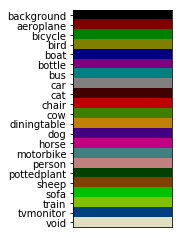

In [25]:
cmap = dataset.cmap
assert len(cmap) == (N_CLASSES + 1)  # Note that a void/ignore label has been appended to the color map
dataset.color_map_viz(CLASS_LABELS)

Display a few samples with their labels mask overlayed.

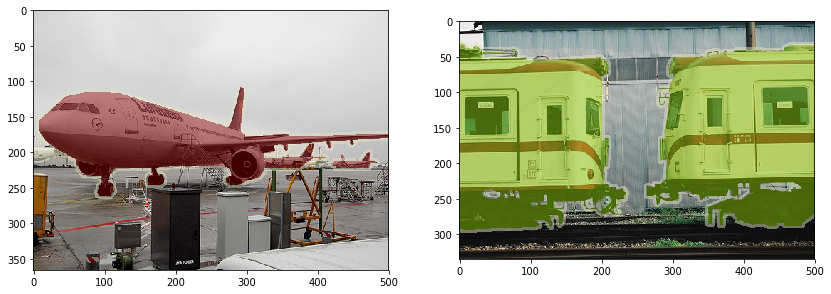

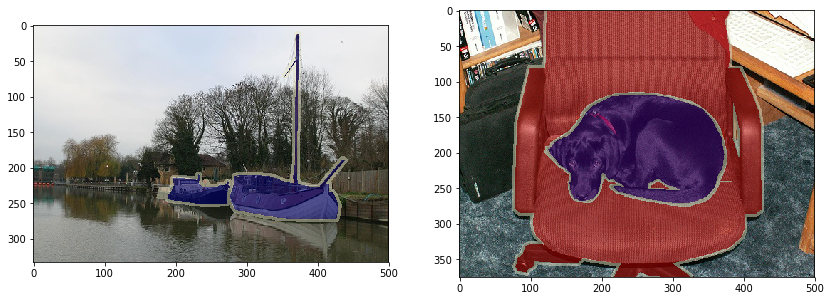

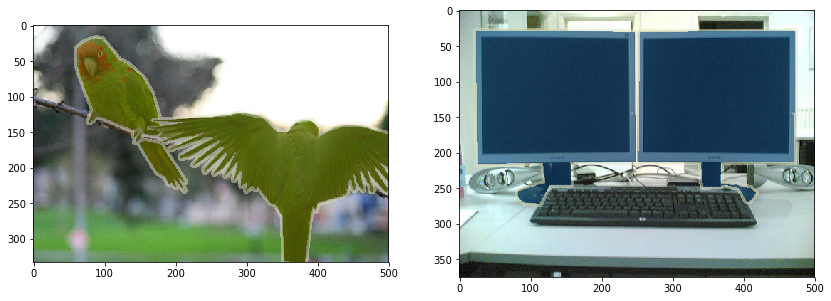

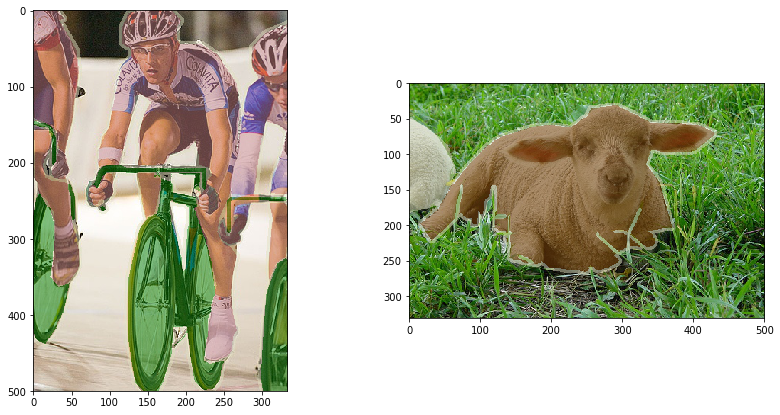

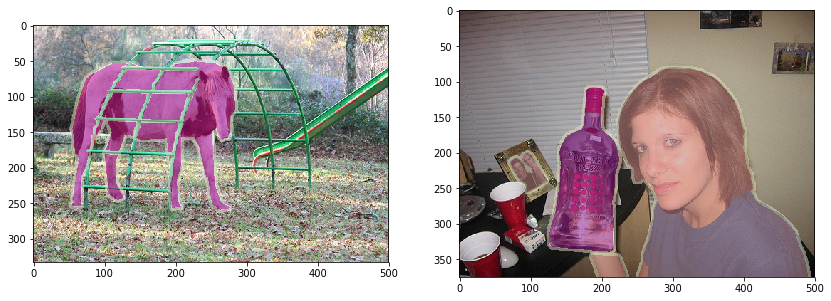

In [26]:
dual_plot(utils.apply_mask(*load_sample('2007_000033')), utils.apply_mask(*load_sample('2007_000042')))
dual_plot(utils.apply_mask(*load_sample('2007_000061')), utils.apply_mask(*load_sample('2007_000063')))
dual_plot(utils.apply_mask(*load_sample('2007_000363')), utils.apply_mask(*load_sample('2007_000121')))
dual_plot(utils.apply_mask(*load_sample('2007_000129')), utils.apply_mask(*load_sample('2007_000175')))
dual_plot(utils.apply_mask(*load_sample('2007_000332')), utils.apply_mask(*load_sample('2007_000346')))

From now on we will use the first image of the training set.

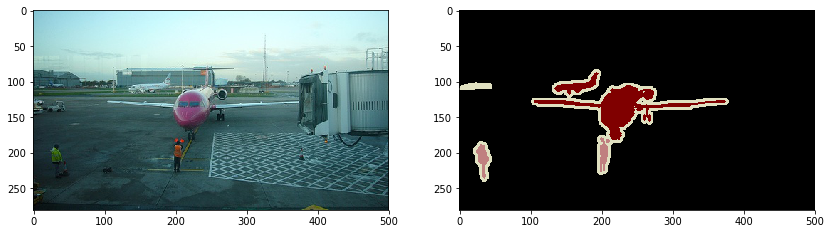

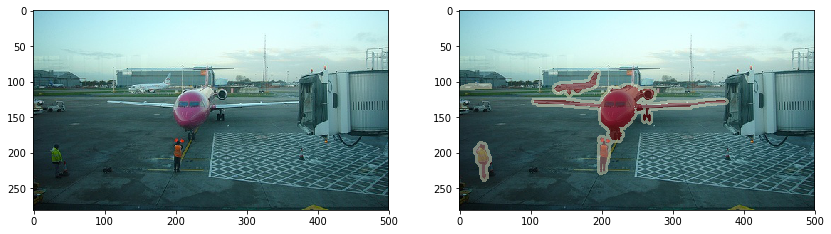

In [27]:
im, gt = load_sample(0)
dual_plot(im, gt)
dual_plot(im, utils.apply_mask(im, gt))

## Step by step image transformation

Image transformations are used to augment the data during training to reduce overfitting.
The following transformations have been implemented:
 - Horizontal flip
 - Translation
 - Zoom
 - Rotation
 - Saturation & value
 - Brighness & contrast

### Image padding

The model requires images of width and height that are multiples of 32. The largest side of all PASCAL VOC images is always 500 pixels. Therefore, after performing the various transformations, the images are padded or cropped to shape (512, 512). By default, the below `pad` function appends new rows and columns and fills them with zeros.

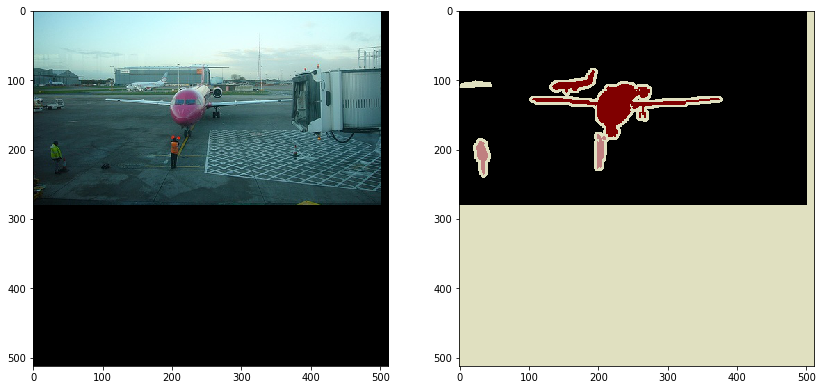

In [28]:
im_padded = utils.pad(im, IMAGE_SHAPE)
gt_padded = utils.pad(utils.colors2labels(gt, cmap), IMAGE_SHAPE, cval=N_CLASSES)
dual_plot(im_padded, utils.labels2colors(gt_padded, cmap))

For efficiency reasons, we'll now work with a sparsely encoded version of the ground truth segmentation image. This matrix of class labels will be colorised when it needs to be displayed.

In [29]:
gt = utils.colors2labels(gt, cmap)

### Simple transformation with horizontal flipping and jittering

This section implements the data augmentation procedure described in the original paper: "We tried augmenting the training data by randomly mirroring and jittering the images by translating them up to 32 pixels (the coarsest scale of predictions) in each direction."

The jittering (ie. translation) is implemented using a combination of padding and random cropping. I did not use this simple augmentation technique in the final implementation because it delivers no noticeable improvement. It appears not to be sufficient to improve the results, so instead I used a combination of the different transformations listed above including zoom, rotation, and color saturation. This combination is efficient at reducing overfitting and improves the validation metrics.

You may need to run the next cell multiple times to obtain a mirrored image. Notice that from now on, the images are center padded.

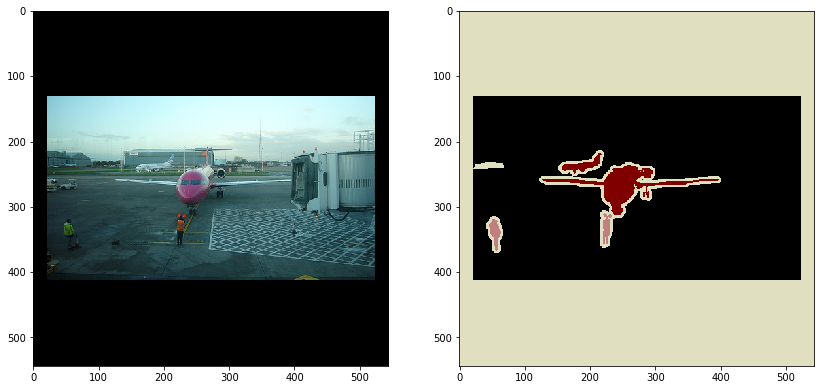

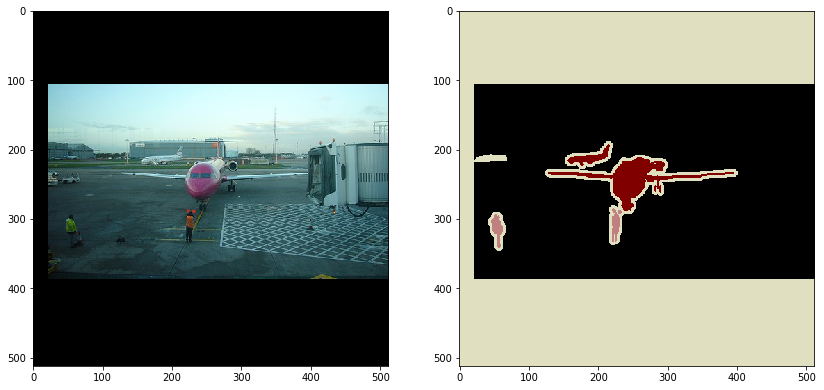

In [30]:
# Randomly flip the image horizontally
x, y = utils.random_flip_axis(im, gt, 1)
x = utils.pad(x, np.asarray(IMAGE_SHAPE)+np.asarray((32, 32)), center=True)
y = utils.pad(y, np.asarray(IMAGE_SHAPE)+np.asarray((32, 32)), center=True, cval=N_CLASSES)
dual_plot(x, utils.labels2colors(y, cmap))

# Randomly crop the image back to the target shape
x, y = utils.random_crop(x, y, (512, 512))
dual_plot(x, utils.labels2colors(y, cmap))

This implementation of the `random_transform` function is provided for reference only. It is not used.

In [31]:
def random_transform(im, gt, target_shape, flip_lr=False, shift_range=None, ignore_label=0):
    """
    Simple transformation with horizontal flipping and jittering as described in the orignal paper.
    """
    x, y = im, gt
    padded_shape = np.asarray(target_shape)
    if shift_range is not None:
        padded_shape += np.asarray(shift_range)
    
    # Horizontal flip
    if flip_lr:
        x, y = utils.random_flip_axis(x, y, 1)
    
    # Translate image using a combination of padding and cropping    
    x = utils.pad(x, padded_shape, center=True)
    y = utils.pad(y, padded_shape, center=True, cval=ignore_label)
    if shift_range is not None:
        x, y = utils.random_crop(x, y, target_shape)
    
    return x, y

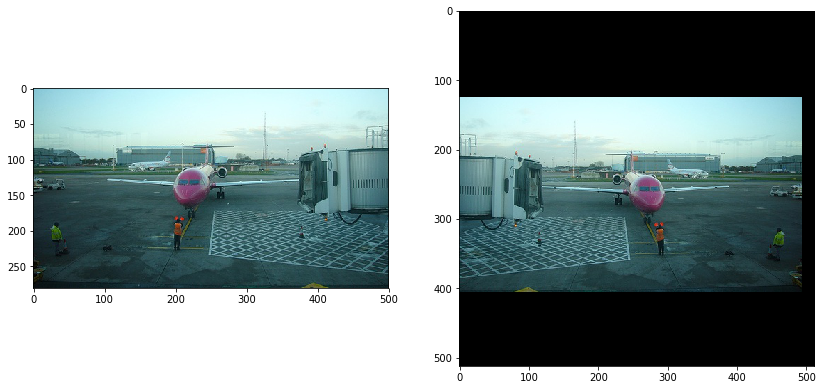

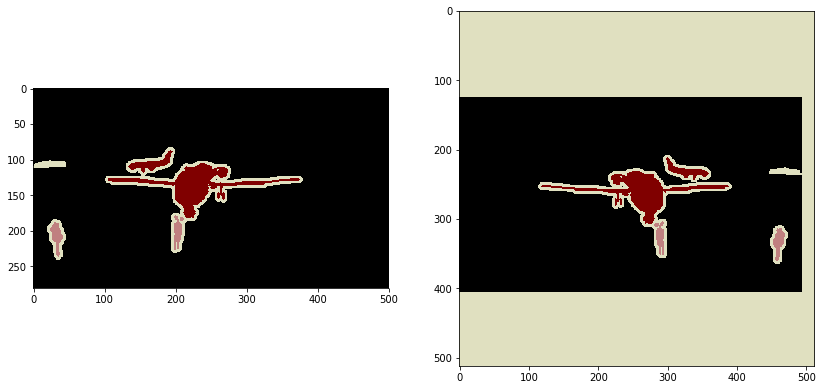

In [32]:
im_t1, gt_t1 = random_transform(im, gt, (512,512), flip_lr=True, shift_range=(32,32), ignore_label=N_CLASSES)

# Plot original image and transformed image
dual_plot(im, im_t1)

# Plot original labels and transformed labels
dual_plot(utils.labels2colors(gt, cmap), utils.labels2colors(gt_t1, cmap))

### Gaussian blur

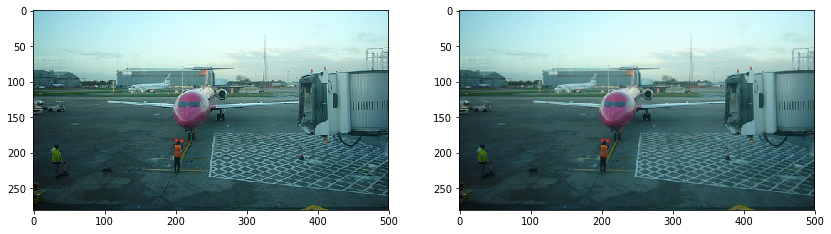

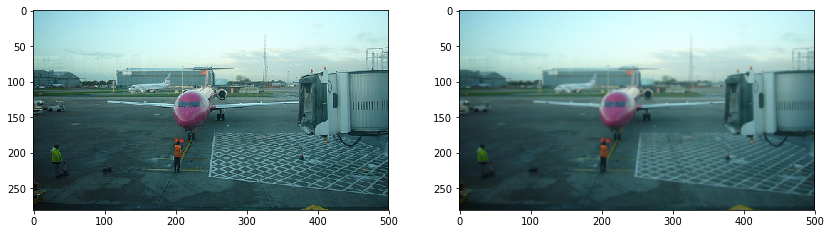

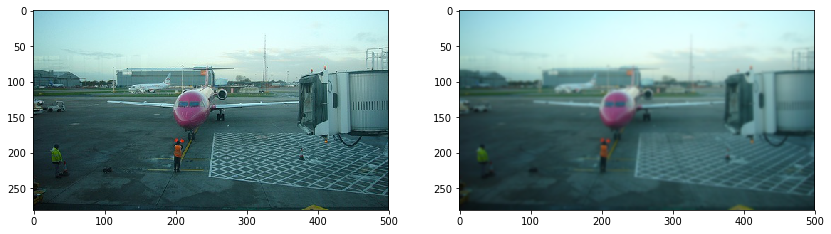

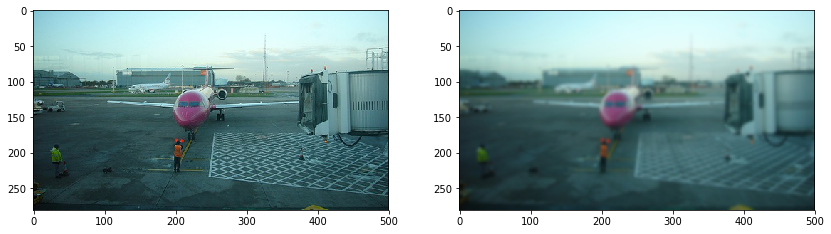

In [33]:
ksize=(11,11)
dual_plot(im, cv2.GaussianBlur(im, ksize, sigmaX=0.5))
dual_plot(im, cv2.GaussianBlur(im, ksize, sigmaX=1))
dual_plot(im, cv2.GaussianBlur(im, ksize, sigmaX=1.5))
dual_plot(im, cv2.GaussianBlur(im, ksize, sigmaX=2))

### Image zoom

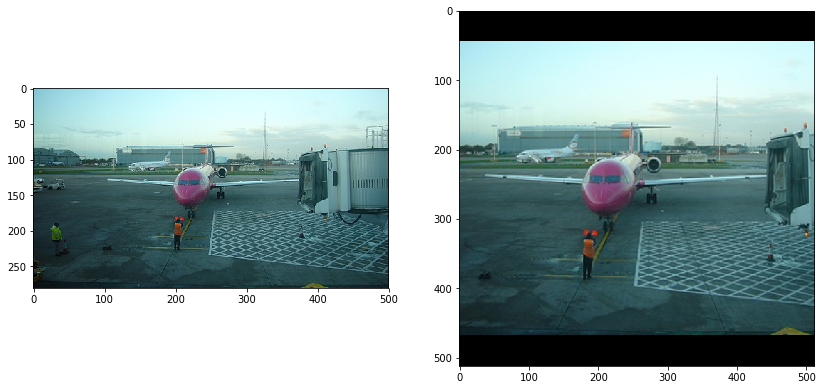

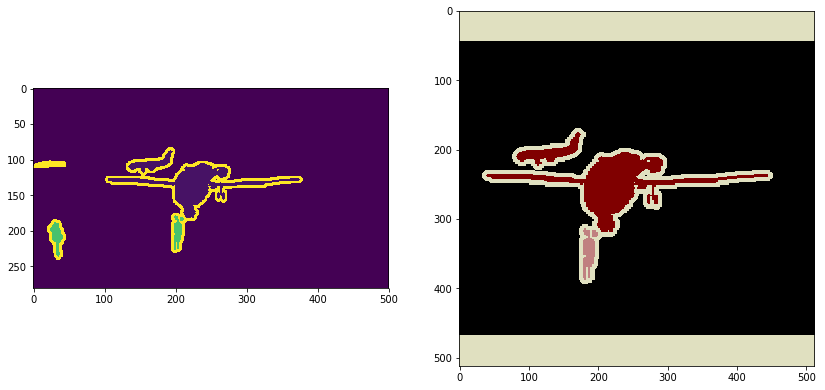

In [34]:
# Apply a random zoom
im_t2, gt_t2 = utils.random_zoom(im, gt, zoom_range=(0.5,2))

# Pads (zoom < 1) or crops (zoom > 1) the image to the target shape
im_t2 = utils.pad_or_crop(im_t2, IMAGE_SHAPE)
gt_t2 = utils.pad_or_crop(gt_t2, IMAGE_SHAPE, cval=N_CLASSES)

# Plots results
dual_plot(im, im_t2)
dual_plot(gt, utils.labels2colors(gt_t2, cmap))

### Image rotation with rescaling

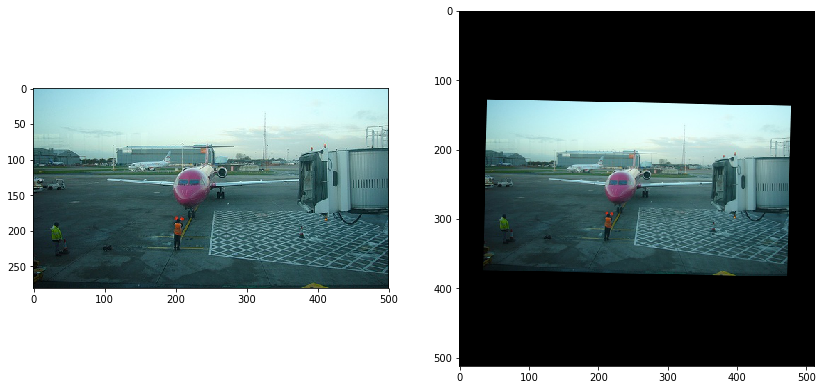

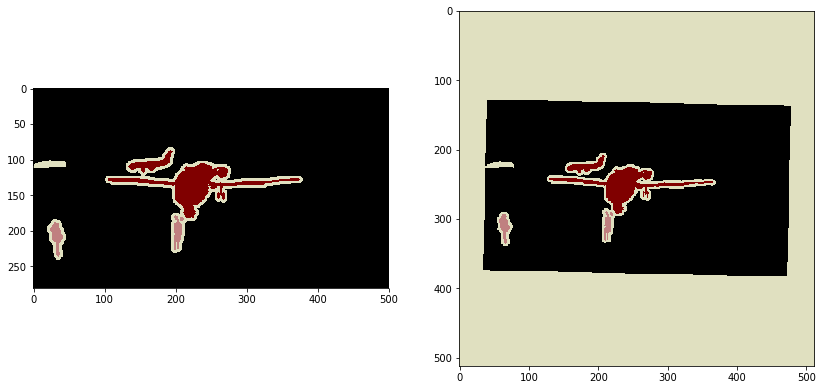

In [35]:
im_t3, gt_t3 = utils.random_rotate(im, gt, rotation_range=[-10, 10], zoom_range=[0.5, 2], ignore_label=N_CLASSES)

# Pads (zoom < 1) or crops (zoom > 1) the image to the target shape
im_t3 = utils.pad_or_crop(im_t3, IMAGE_SHAPE)
gt_t3 = utils.pad_or_crop(gt_t3, IMAGE_SHAPE, cval=N_CLASSES)

dual_plot(im, im_t3)
dual_plot(utils.labels2colors(gt, cmap), utils.labels2colors(gt_t3, cmap))

### Image brightness and contrast

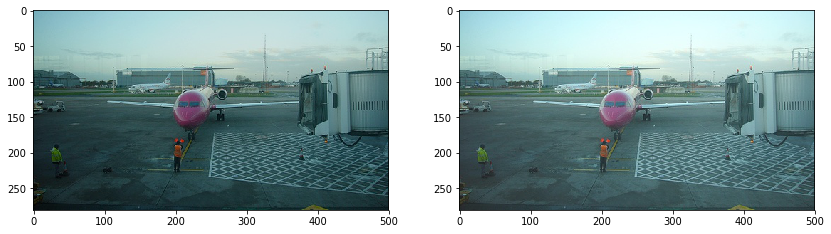

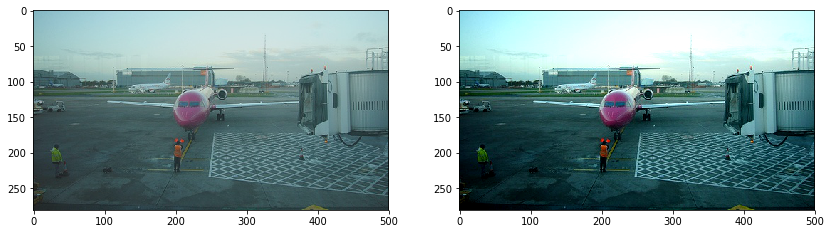

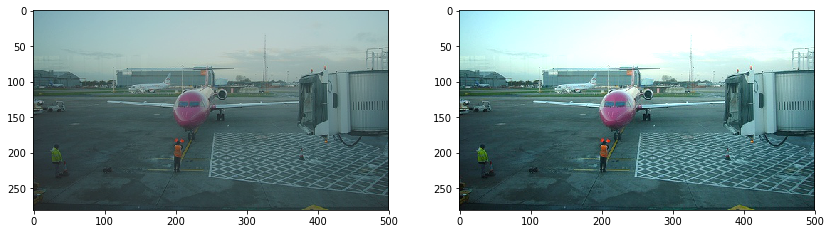

In [36]:
# Adjust brightness only
dual_plot(utils.adjust_brightness_and_contrast(im, -30, 0), utils.adjust_brightness_and_contrast(im, 30, 0))

# Adjust contrasts only
dual_plot(utils.adjust_brightness_and_contrast(im, 0, -15), utils.adjust_brightness_and_contrast(im, 0, 15))

# Adjust both brightness and contrasts
dual_plot(utils.adjust_brightness_and_contrast(im, -30, -15), utils.adjust_brightness_and_contrast(im, 30, 15))

### Image saturation and value

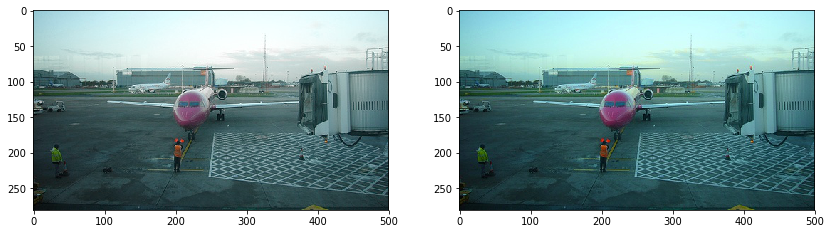

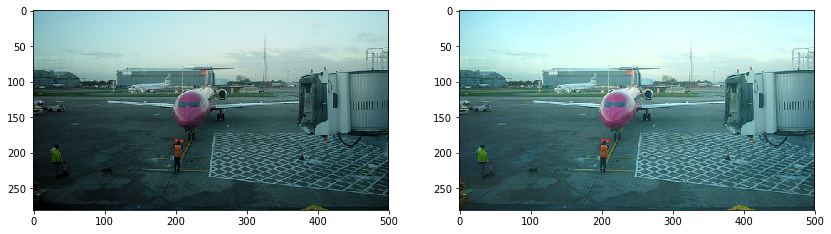

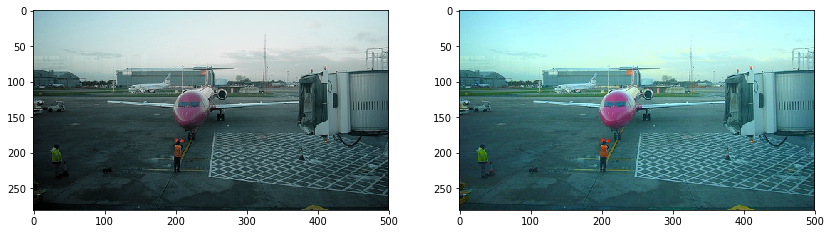

In [37]:
# Adjust saturation only
dual_plot(utils.adjust_saturation_and_value(im, -20, 0), utils.adjust_saturation_and_value(im, 20, 0))

# Adjust value only
dual_plot(utils.adjust_saturation_and_value(im, 0, -20), utils.adjust_saturation_and_value(im, 0, 20))

# Adjust saturation and value 
dual_plot(utils.adjust_saturation_and_value(im, -20, -20), utils.adjust_saturation_and_value(im, 20, 20))

### Putting all transformations together

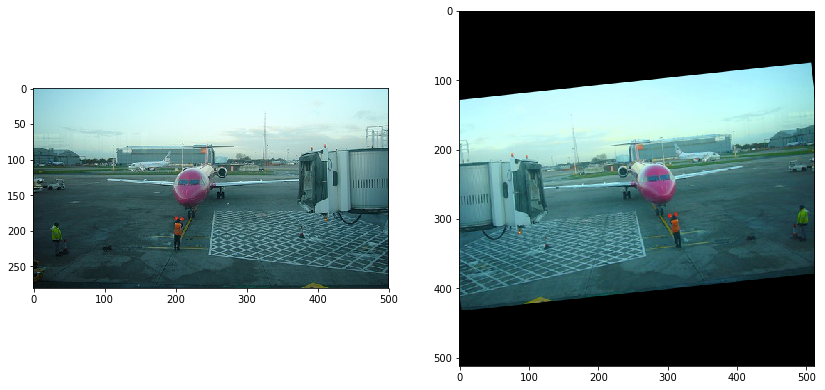

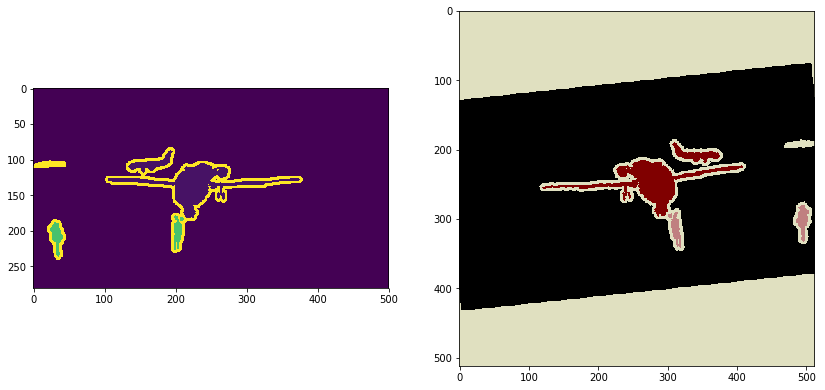

In [38]:
im_t4, gt_t4 = utils.random_transform(im, gt, IMAGE_SHAPE, saturation_range=(15, 20), value_range=(15, 20), flip_lr=True, 
                                      rotation_range=(5, 10), shift_range=(32, 32), zoom_range=(0.5, 2), 
                                      ignore_label=N_CLASSES)
dual_plot(im, im_t4)
dual_plot(gt, utils.labels2colors(gt_t4, cmap))

## Data Augmentation with the TF Record Dataset

In [39]:
AUGMENTATION_PARAMS = {'saturation_range': (-20, 20), 'value_range': (-20, 20), 'brightness_range': None, 
                       'contrast_range': None, 'blur_params': {'ksize_max': (11, 11), 'sigma_max': (1.5, 1.5)}, 
                       'flip_lr': True, 'rotation_range': (-10, 10), 'shift_range': (32, 32),
                       'zoom_range': (0.5, 2.0), 'ignore_label': N_CLASSES}

In [40]:
def parse_record(record):
    keys_to_features = {
        'height': tf.FixedLenFeature([1], tf.int64),
        'width': tf.FixedLenFeature([1], tf.int64),
        'depth': tf.FixedLenFeature([1], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label_raw': tf.FixedLenFeature([], tf.string)
    }
    parsed = tf.parse_single_example(record, keys_to_features)

    # Decode the raw data
    im = tf.image.decode_png(parsed["image_raw"])
    gt = tf.io.decode_raw(parsed['label_raw'], tf.uint8)
    gt = tf.reshape(gt, [tf.cast(parsed["height"][0], tf.int64), tf.cast(parsed["width"][0], tf.int64)])
    
    return im, gt


def transform_record(im, gt):
    return utils.random_transform(im, gt, IMAGE_SHAPE, **AUGMENTATION_PARAMS)

In [41]:
ops.reset_default_graph()
sess = tf.Session()

dataset_train = tf.data.TFRecordDataset(
    os.path.join(DATASET_PATH, 'VOCdevkit/VOC2012/TFRecords', 'segmentation_train.tfrecords'), num_parallel_reads=4)
dataset_train = dataset_train.map(parse_record)
dataset_train = dataset_train.map(
    lambda im, gt: tuple(tf.py_func(transform_record, [im, gt], [im.dtype, tf.uint8])))

iterator = dataset_train.make_one_shot_iterator()
next_batch = iterator.get_next()

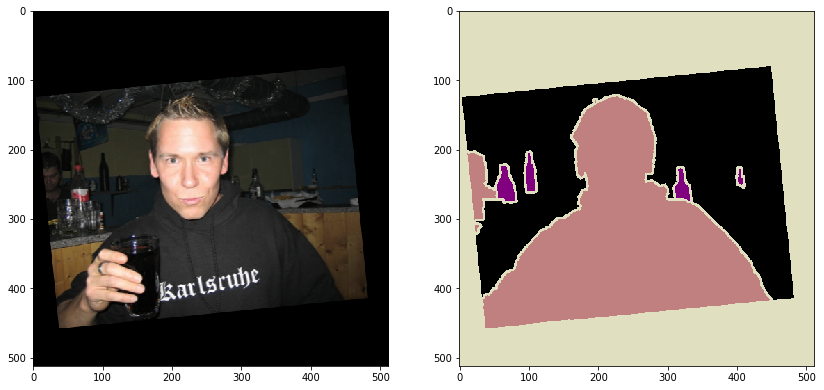

In [53]:
parsed = sess.run(next_batch)
dual_plot(parsed[0], utils.labels2colors(parsed[1], cmap))